In [1]:
import tensorflow as tf
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras import backend as K

import random
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [ ]:
#path for saving the trained model
model_save_file = "tensorflow1_big.data.89.2.acc.mod.keras"

In [5]:
#Loading of train and validation/test files

xtrain = np.load("data/xtrain.npy", mmap_mode='r')
ytrain = np.load("data/ytrain.npy", mmap_mode='r')

xtest = np.load("data/xtest.npy", mmap_mode='r')
ytest = np.load("data/ytest.npy", mmap_mode='r')

In [6]:
# Define hyperparameters
batch_size = 256
epochs = 19
num_classes = 3

In [7]:
#get length of training set
indices = list(range(xtrain.shape[0]))

In [9]:
#data loader class
class NpySequence(tf.keras.utils.Sequence):

    def __init__(self, data_name, labels_name, batch_size):
        self.data = np.load(data_name, mmap_mode='r')
        self.labels = np.load(labels_name, mmap_mode='r')

        self.indices = list(range(self.data.shape[0]))
        random.shuffle(self.indices)

        self.batch_size = batch_size

    def __len__(self):
        return len(self.data) // self.batch_size
    
    def on_epoch_end(self):
        #print('on_epoch_end')
        random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idxs = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        xbatch = [self.data[batch_idx] for batch_idx in batch_idxs]
        ybatch = [self.labels[batch_idx] for batch_idx in batch_idxs]

                
        xbatch = np.array(xbatch)   
        ybatch = np.array(ybatch)

        ybatch = keras.utils.to_categorical(ybatch, num_classes)

        return xbatch, ybatch

In [10]:
#model specification

model = Sequential()
model.add(Conv1D(256, kernel_size=2,
                 activation='relu',
                 input_shape=(xtest.shape[1], xtest.shape[2])))
model.add(Conv1D(128, kernel_size=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, kernel_size=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1200, 256)         17664     
                                                                 
 conv1d_1 (Conv1D)           (None, 1199, 128)         65664     
                                                                 
 average_pooling1d (AverageP  (None, 599, 128)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 599, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 598, 128)          32896     
                                                                 
 average_pooling1d_1 (Averag  (None, 299, 128)         0         
 ePooling1D)                                            

In [11]:
#create data generators using custom dataloader
train_data_generator = NpySequence("xtrain.npy", "ytrain.npy", batch_size)
test_data_generator = NpySequence("xtest.npy", "ytest.npy", batch_size)


In [12]:
#training of model
model.fit(train_data_generator,
          epochs=epochs,
          validation_data=test_data_generator)

Epoch 1/19
869/869 [==============================] - 102s 112ms/step - loss: 0.5227 - accuracy: 0.7599 - val_loss: 0.3854 - val_accuracy: 0.8588
on_epoch_end
Epoch 2/19
869/869 [==============================] - 94s 109ms/step - loss: 0.4024 - accuracy: 0.8315 - val_loss: 0.3378 - val_accuracy: 0.8755
on_epoch_end
Epoch 3/19
869/869 [==============================] - 95s 109ms/step - loss: 0.3731 - accuracy: 0.8468 - val_loss: 0.3517 - val_accuracy: 0.8699
on_epoch_end
Epoch 4/19
869/869 [==============================] - 94s 109ms/step - loss: 0.3568 - accuracy: 0.8549 - val_loss: 0.3908 - val_accuracy: 0.8636
on_epoch_end
Epoch 5/19
869/869 [==============================] - 95s 109ms/step - loss: 0.3461 - accuracy: 0.8606 - val_loss: 0.3450 - val_accuracy: 0.8714
on_epoch_end
Epoch 6/19
869/869 [==============================] - 95s 109ms/step - loss: 0.3373 - accuracy: 0.8644 - val_loss: 0.3603 - val_accuracy: 0.8653
on_epoch_end
Epoch 7/19
869/869 [==============================]

In [14]:
#saving of model
model.save(filepath=model_save_file)

In [15]:
#evaluation

pred = model.predict(xtest)
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))

235/235 [==============================] - 8s 30ms/step
[[2301    2  197]
 [  40 2236  224]
 [ 470  370 1660]]


In [29]:
true_labels_tensor = tf.convert_to_tensor(ytest, dtype=tf.int64)
predicted_labels_tensor = tf.convert_to_tensor(pred_cat, dtype=tf.int64)

#calculation of accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels_tensor, predicted_labels_tensor), tf.float32))
print("Accuracy:", accuracy.numpy())

Accuracy: 0.82626665


In [30]:
#alternative calculation of accuracy
def compute_accuracy(true_labels, predicted_labels):

    correct_count = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)

    accuracy = correct_count / len(true_labels)

    return accuracy

accuracy = compute_accuracy(ytest, pred_cat)

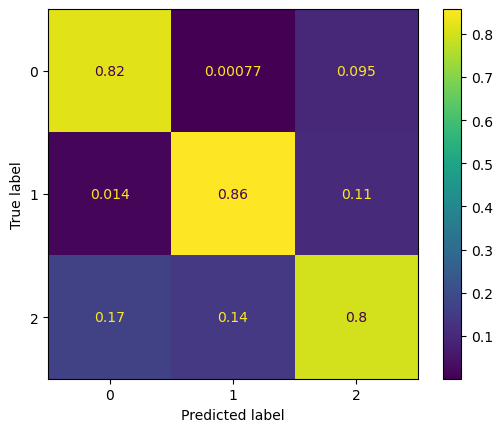

In [16]:
#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(ytest, pred_cat, normalize="pred")

In [26]:
#another way to plot the confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, classes, normalize=True, title="confusion matrix"):

    #confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    #normalization
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    #plotting using sns
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

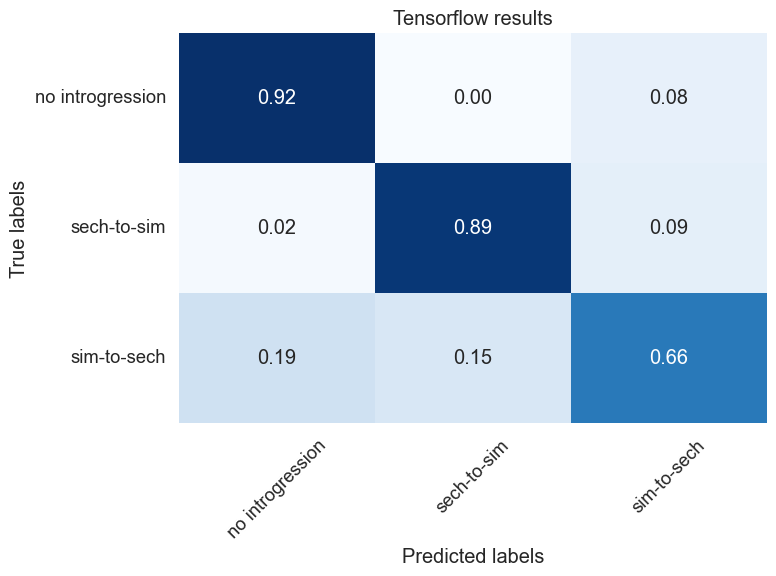

In [27]:
plot_confusion_matrix(ytest, pred_cat, classes=['no introgression', 'sech-to-sim', 'sim-to-sech'], title="Tensorflow results")